In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_train.csv
/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_submission.csv
/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_test.csv
/kaggle/input/covid19-in-usa/us_covid19_daily.csv
/kaggle/input/covid19-in-usa/us_states_covid19_daily.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


### Train Dataset Visualization

In [3]:
train = pd.read_csv('/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_train.csv')
train.Date = pd.to_datetime(train.Date)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 8 columns):
Id                63 non-null int64
Province/State    63 non-null object
Country/Region    63 non-null object
Lat               63 non-null float64
Long              63 non-null float64
Date              63 non-null datetime64[ns]
ConfirmedCases    63 non-null float64
Fatalities        63 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.1+ KB


In [4]:
train

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,California,US,36.1162,-119.6816,2020-01-22,0.0,0.0
1,2,California,US,36.1162,-119.6816,2020-01-23,0.0,0.0
2,3,California,US,36.1162,-119.6816,2020-01-24,0.0,0.0
3,4,California,US,36.1162,-119.6816,2020-01-25,0.0,0.0
4,5,California,US,36.1162,-119.6816,2020-01-26,0.0,0.0
...,...,...,...,...,...,...,...,...
58,59,California,US,36.1162,-119.6816,2020-03-20,1177.0,23.0
59,60,California,US,36.1162,-119.6816,2020-03-21,1364.0,24.0
60,61,California,US,36.1162,-119.6816,2020-03-22,1642.0,30.0
61,62,California,US,36.1162,-119.6816,2020-03-23,2108.0,39.0


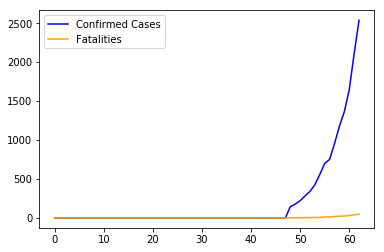

In [5]:
cc = train.ConfirmedCases.values
f = train.Fatalities.values
plt.plot(cc, color = 'blue', label = 'Confirmed Cases')
plt.plot(f, color = 'orange', label = 'Fatalities')
plt.legend()
plt.show()

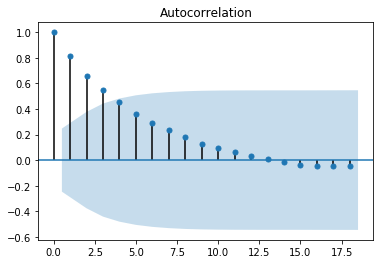

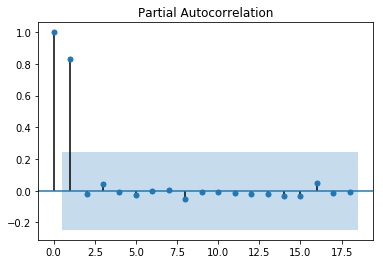

In [6]:
plot_acf(cc)
plot_pacf(cc)
plt.show()

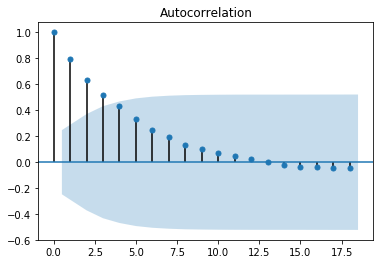

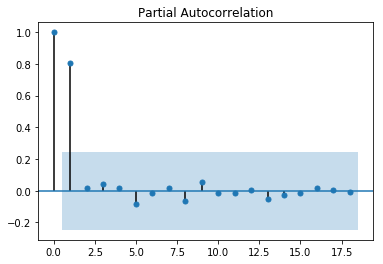

In [7]:
plot_acf(f)
plot_pacf(f)
plt.show()

### Simple LSTM Model

In [8]:
ccf = train[['ConfirmedCases', 'Fatalities']]
ccf = ccf[ccf.ConfirmedCases > 0].values
ccf_max, ccf_min = np.max(ccf), np.min(ccf)
ccf_norm = (ccf - ccf_min) / (ccf_max - ccf_min)

X, y = [], []
for i in range(len(ccf_norm)):
    end = i+2
    if end > len(ccf_norm)-1:
        break
    X.append(ccf_norm[i:end])
    y.append(ccf_norm[end])
    
X, y = np.array(X).reshape(-1, 2, 2), np.array(y)
print(X.shape, y.shape)

(13, 2, 2) (13, 2)


In [9]:
tf.random.set_seed(1)

m = Sequential()
m.add(LSTM(100, input_shape = (X.shape[1], X.shape[2]), activation = 'relu'))
m.add(Dense(2))
m.compile(loss = 'mse', optimizer = 'adam')
h = m.fit(X, y, epochs = 100, verbose = 0)

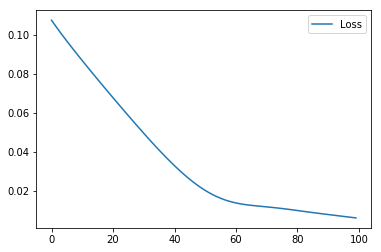

In [10]:
plt.plot(h.history['loss'], label = 'Loss')
plt.legend()
plt.show()

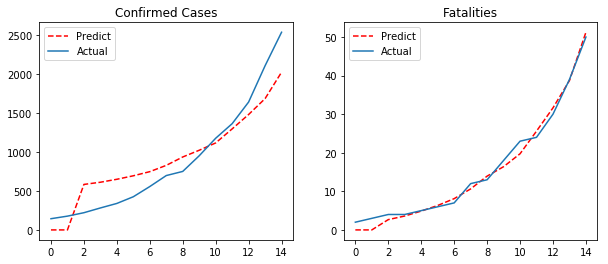

In [11]:
plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.title('Confirmed Cases')
plt.plot(np.pad((m.predict(X) * (ccf_max - ccf_min) + ccf_min)[:,0], (2,0)), 'r--', label = 'Predict')
plt.plot(ccf[:,0], label = 'Actual')
plt.legend()

plt.subplot(122)
plt.title('Fatalities')
plt.plot(np.pad((m.predict(X) * (ccf_max - ccf_min) + ccf_min)[:,1], (2,0)), 'r--', label = 'Predict')
plt.plot(ccf[:,1], label = 'Actual')
plt.legend()
plt.show()

### Predictions

In [12]:
test = pd.read_csv('/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_test.csv')
pd.concat([test.head(1), test.tail(1)])

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,California,US,36.1162,-119.6816,2020-03-12
42,43,California,US,36.1162,-119.6816,2020-04-23


In [13]:
test_pred = y[-2:]
n = len(test) - len(train[train.Date >= '2020-03-12'])
for i in range(n):
    p = m.predict(test_pred[-2:].reshape(-1, 2, 2))
    test_pred = np.append(test_pred, p).reshape(-1, 2)
    i += 1

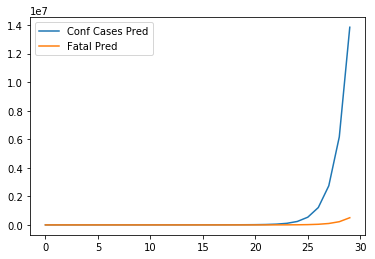

In [14]:
test_pred_round = np.round(test_pred * (ccf_max - ccf_min) + ccf_min, 0)[:-2]
plt.plot(test_pred_round[:,0], label = 'Conf Cases Pred')
plt.plot(test_pred_round[:,1], label = 'Fatal Pred')
plt.legend()
plt.show()

> Submission

In [15]:
sub = pd.read_csv('/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_submission.csv')

In [16]:
cc_sub = np.append(train[train.Date >= '2020-03-12'].ConfirmedCases.values, test_pred_round[:, 0])
f_sub = np.append(train[train.Date >= '2020-03-12'].Fatalities.values, test_pred_round[:, 1])

In [17]:
sub = sub.assign(ConfirmedCases = cc_sub, Fatalities = f_sub)
sub.to_csv('submission.csv', index = False)